In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
import os
os.chdir("/content/gdrive/MyDrive/xai-lab")

In [5]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, fasterrcnn_resnet50_fpn
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from src.faster_rcnn import fasterrcnn_resnet18_fpn

In [6]:
device = torch.device('cuda') # if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# Finetune pre-trained model

In [12]:
# load an instance segmentation model pre-trained pre-trained on COCO
# model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True, num_classes=num_classes)
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, num_classes=num_classes)
model = fasterrcnn_resnet18_fpn(pretrained_backbone=True, num_classes=num_classes)
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# load model checkpoint
path = os.path.join(os.getcwd(), "./checkpoints/faster_rcnn_resnet1810_epochs.ckpt")
checkpoint = torch.load(path)
model.load_state_dict(checkpoint['model_state_dict'])

model.to(device) 

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride

# Dataset

In [15]:
os.chdir("/content/gdrive/MyDrive/xai-lab/detection")

from pennfudan_dataset import PennFudanDataset, get_transform
from utils import collate_fn

# use our dataset and defined transformations
dataset = PennFudanDataset('../PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('../PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=2, shuffle=True, num_workers=4,
        collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=1, shuffle=False, num_workers=4,
        collate_fn=collate_fn)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [16]:
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9) #weight_decay=0.0005)
# and a learning rate scheduler
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
#                                                step_size=3,
#                                                gamma=0.1)

In [17]:
!pip install --upgrade torch==1.10.0
!pip install --upgrade torchvision

In [ ]:
from engine import train_one_epoch, evaluate

# let's train it for 20 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    # lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [0]  [ 0/60]  eta: 0:01:23  lr: 0.000090  loss: 0.1440 (0.1440)  loss_classifier: 0.0298 (0.0298)  loss_box_reg: 0.0993 (0.0993)  loss_objectness: 0.0020 (0.0020)  loss_rpn_box_reg: 0.0128 (0.0128)  time: 1.3863  data: 0.3580  max mem: 2636
Epoch: [0]  [10/60]  eta: 0:00:51  lr: 0.000936  loss: 0.0942 (0.0985)  loss_classifier: 0.0265 (0.0269)  loss_box_reg: 0.0632 (0.0634)  loss_objectness: 0.0012 (0.0016)  loss_rpn_box_reg: 0.0039 (0.0065)  time: 1.0275  data: 0.0430  max mem: 2636
Epoch: [0]  [20/60]  eta: 0:00:39  lr: 0.001783  loss: 0.0909 (0.0990)  loss_classifier: 0.0249 (0.0268)  loss_box_reg: 0.0566 (0.0645)  loss_objectness: 0.0011 (0.0019)  loss_rpn_box_reg: 0.0041 (0.0058)  time: 0.9781  data: 0.0128  max mem: 2636
Epoch: [0]  [30/60]  eta: 0:00:30  lr: 0.002629  loss: 0.0774 (0.0941)  loss_classifier: 0.0223 (0.0267)  loss_box_reg: 0.0546 (0.0607)  loss_objectness: 0.0009 (0.0017)  loss_rpn_box_reg: 0.0040 (0.0050)  time: 0.9951  data: 0.0140  max mem: 2636
Epoch: [

In [19]:
# pick one image from the test set
img, _ = dataset_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [20]:
from PIL import Image, ImageDraw

result = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
image = ImageDraw.Draw(result)  

for bbox in prediction[0]["boxes"]:
  image.rectangle(bbox.cpu().numpy().tolist(), outline ="red")



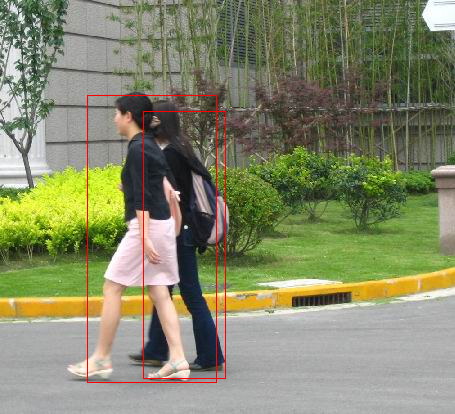

In [21]:
result

In [ ]:
# Save checkpoint
path = os.path.join(os.getcwd(), "..", "checkpoints" ,"faster_rcnn_resnet18" + str(20) + "_epochs.ckpt")
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, path)

In [ ]:
# Test loading of checkpoint

checkpoint = torch.load(path)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>